<details>
   <summary>Metadata</summary>
    title: "E-TRAINEE Tutorial - Forest disturbance assessment with Python and the GEE"<br>
    description: "This is a tutorial within the fourth theme of Module 1 of the E-TRAINEE course."<br>
    lastUpdate: 2025-04-03<br>
    authors: Andreas Mayr<br>
</details>

# Forest disturbance assessment with Python and the GEE

We want to compare the NDVI time series (spectral-temporal profile) for a disturbed forest location and for an undisturbed location to assess the timing of forest disturbance.

This notebook introduces possibilities for working with Python, the Google Earth Engine (GEE) and additional (helper) packages. You will learn how to extract spectral-temporal profiles for defined locations using the following packages:
- [ee](https://developers.google.com/earth-engine/guides/python_install) - The GEE Python API.
- [geemap](https://geemap.org/geemap) - A Python package described in [Wu (2020)](https://doi.org/10.21105/joss.02305). The geemap tools facilitate interactive mapping but also some other tasks with GEE.
- [eemont](https://eemont.readthedocs.io/) - This package adds utility methods for different Earth Engine Objects which are friendly with Python method chaining ([Montero 2021](https://doi.org/10.21105/joss.03168)). Thereby, the complexity of the code needed for processing tasks like cloud masking and spectral index calculation is reduced.
- [pandas](https://pandas.pydata.org/) and [seaborn](https://seaborn.pydata.org/) are used to process and plot the point-based time series

These packages are contained in the requirements file provided for the course. Please see the instructions on the [software page](https://3dgeo-heidelberg.github.io/etrainee/software/software_python.html) for setting up a Conda environment based on this file.

*Note:* You will need a Google account with GEE activated ([Sign up here](https://earthengine.google.com/signup/), if you do not already have one.).

## Define points-of-interest

Start with importing the required packages.

In [1]:
import ee, eemont, geemap         # ee is the GEE Python API
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

Authenticate and initialize Earth Engine.

In [2]:
try:
        ee.Initialize()
except Exception as e:          # If initialize does not work, you probably have to authenticate first
        ee.Authenticate()
        ee.Initialize()

We want to compare the NDVI time series (spectral-temporal profile) for two points-of-interest: a disturbed forest location and an undisturbed location. Create a GEE FeatureCollection by defining locations as geographic coordinates (copied from QGIS) and adding a buffer around each point.

In [3]:
lat = [47.2989635, 47.300451]   # two latitude values, one for each point
lon = [11.4038744, 11.417014]   # two longitude values, one for each point
mypoints = ee.FeatureCollection([
    ee.Feature(ee.Geometry.Point([lon[0],lat[0]]).buffer(50),{'point_ID':1}),   # a location with disturbed forest
    ee.Feature(ee.Geometry.Point([lon[1],lat[1]]).buffer(50),{'point_ID':2})    # an undisturbed location
])

Let's use the geemap package to display our locations on a map.

In [4]:
Map = geemap.Map()
Map.addLayer(mypoints,{'color':'blue'})
Map.centerObject(mypoints,14)       # we provide a zoom level here (14)
Map

Map(center=[47.299707488940804, 11.410444109531477], controls=(WidgetControl(options=['position', 'transparent…

## Extract time series for regions

### Query GEE image collection

Query the [Landsat 8](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C02_T1_L2) image collection from the Google Earth Engine centered around our points-of-interest (a FeatureCollection), and preprocess the image collection. We also calculate two different vegetation indices. The eemont package provides functions to make this easy.

In [6]:
L8 = (ee.ImageCollection('LANDSAT/LC08/C02/T1_L2')         # Landsat Collection 2
      .filterBounds(mypoints)
      .maskClouds()
      .scaleAndOffset()
      .spectralIndices(['NDVI', 'EVI']))

The eemont package has a function for extracting spectral time series for regions. As regions we use the FeatureCollection containing our points with a buffer. We aggregate the pixels inside the buffer by taking the mean value at each time stamp.

In [7]:
L8_point_ts = L8.getTimeSeriesByRegions(collection = mypoints,
                              bands = ['NDVI', 'EVI'],
                              reducer = ee.Reducer.mean(),
                              scale = 30)

## Convert time series to Pandas

To utilize the plotting and analysis functionality of Pandas, we convert the time series retrieved as a feature collection to a Pandas DataFrame.

In [9]:
tsPandas = geemap.ee_to_df(L8_point_ts)
tsPandas

,EVI,NDVI,date,point_ID,reducer
0,-9999.000000,-9999.000000,2013-03-24T10:00:18,1,mean
1,-9999.000000,-9999.000000,2013-03-24T10:00:18,2,mean
2,-9999.000000,-9999.000000,2013-04-13T09:59:46,1,mean
3,0.372173,0.727509,2013-04-13T09:59:46,2,mean
4,-9999.000000,-9999.000000,2013-05-15T09:59:56,1,mean
...,...,...,...,...,...
957,-9999.000000,-9999.000000,2025-02-16T10:04:08,2,mean
958,0.289334,0.419637,2025-03-04T10:04:00,1,mean
959,0.308953,0.795218,2025-03-04T10:04:00,2,mean
960,0.285054,0.423155,2025-03-20T10:03:49,1,mean


Replace all -9999 values by NaN (NoData, 'not-a-number'), and convert the date from string to a date data type.

In [10]:
tsPandas[tsPandas == -9999] = np.nan
tsPandas['date'] = pd.to_datetime(tsPandas['date'],infer_datetime_format = True)
tsPandas

,EVI,NDVI,date,point_ID,reducer
0,NaN,NaN,2013-03-24 10:00:18,1,mean
1,NaN,NaN,2013-03-24 10:00:18,2,mean
2,NaN,NaN,2013-04-13 09:59:46,1,mean
3,0.372173,0.727509,2013-04-13 09:59:46,2,mean
4,NaN,NaN,2013-05-15 09:59:56,1,mean
...,...,...,...,...,...
957,NaN,NaN,2025-02-16 10:04:08,2,mean
958,0.289334,0.419637,2025-03-04 10:04:00,1,mean
959,0.308953,0.795218,2025-03-04 10:04:00,2,mean
960,0.285054,0.423155,2025-03-20 10:03:49,1,mean


## Visualization

We use ```seaborn``` (imported as sns in the beginning) to visualize our time series.

<Axes: xlabel='date', ylabel='NDVI'>

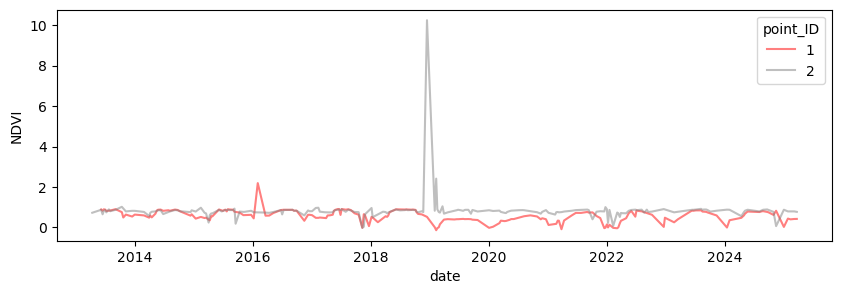

In [11]:
plt.figure(figsize = (10,3))
sns.lineplot(data = tsPandas,
             x = 'date',
             y = 'NDVI',
             palette = ['red', 'grey'],
             hue = 'point_ID',
             alpha = 0.5)

The NDVI time series seems to contain a few outliers. Let's simply filter them by setting all NDVI values > 1 to NaN. Then plot again.

<Axes: xlabel='date', ylabel='NDVI'>

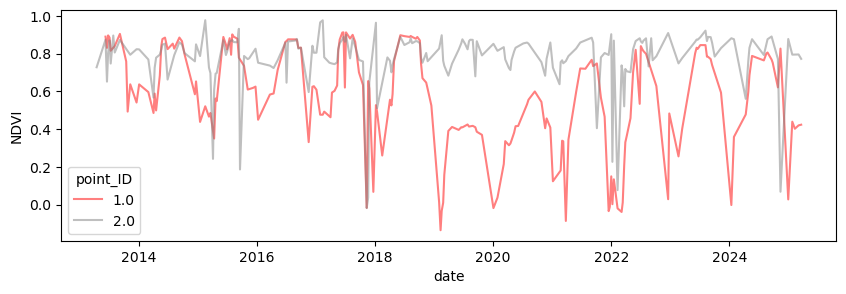

In [13]:
# Set NDVI values > 1 to NaN
tsPandas[tsPandas['NDVI'] > 1] = np.nan

# Plot NDVI time series without outliers
plt.figure(figsize = (10,3))
sns.lineplot(data = tsPandas,
             x = 'date',
             y = 'NDVI',
             palette = ['red', 'grey'],
             hue = 'point_ID',
             alpha = 0.5)

Or plot each spectral-temporal profile in a separate panel:

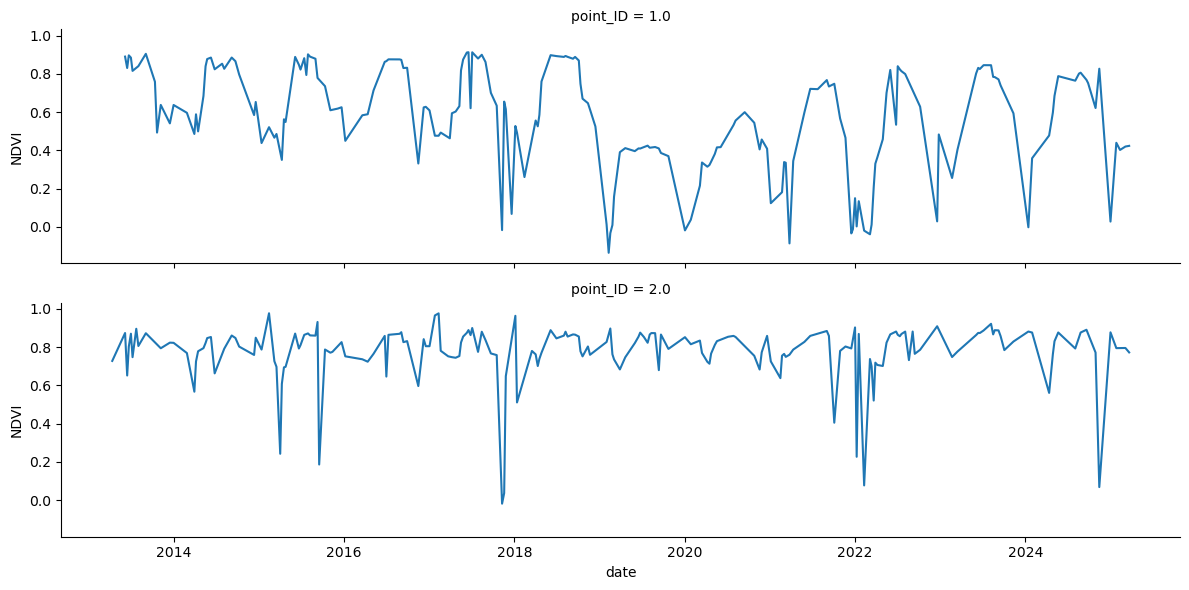

In [24]:
myplot = sns.FacetGrid(tsPandas,row = 'point_ID',height = 3,aspect = 4)
myplot.map_dataframe(sns.lineplot,x = 'date',y = 'NDVI')

## Temporal aggregations

To perform temporal aggregations (such as computing monthly means) we need a DataFrame with DatetimeIndex. So we set the date column as index.

In [15]:
tsPandas_indexed = tsPandas.set_index('date')
tsPandas_indexed

,EVI,NDVI,point_ID,reducer
date,,,,
2013-03-24 10:00:18,NaN,NaN,1.0,mean
2013-03-24 10:00:18,NaN,NaN,2.0,mean
2013-04-13 09:59:46,NaN,NaN,1.0,mean
2013-04-13 09:59:46,0.372173,0.727509,2.0,mean
2013-05-15 09:59:56,NaN,NaN,1.0,mean
...,...,...,...,...
2025-02-16 10:04:08,NaN,NaN,2.0,mean
2025-03-04 10:04:00,0.289334,0.419637,1.0,mean
2025-03-04 10:04:00,0.308953,0.795218,2.0,mean


Next, we want the NDVI data of each point in a separate column.

In [16]:
tsPandas_pv = pd.pivot_table(tsPandas, index='date', values='NDVI', columns='point_ID')
tsPandas_pv

point_ID,1.0,2.0
date,,
2013-04-13 09:59:46,NaN,0.727509
2013-06-07 10:06:10,0.889711,0.873485
2013-06-16 09:59:55,0.830282,0.651367
2013-06-23 10:06:04,0.896309,0.802723
2013-07-02 09:59:56,0.884400,0.869823
...,...,...
2024-12-30 10:04:11,0.027298,0.877080
2025-01-24 09:57:57,0.439180,0.794412
2025-02-09 09:58:00,0.401800,NaN


Now we can compute aggregate statistics (such as the mean, maximum, minimum, median) over defined time periods. This will smooth the time series and make it easier to grasp certain patterns from the plots.

In [17]:
tsPandas_monthly = tsPandas_pv.resample('M').max()
tsPandas_3monthly = tsPandas_pv.resample('3M').max()
tsPandas_yearly = tsPandas_pv.resample('Y').max()

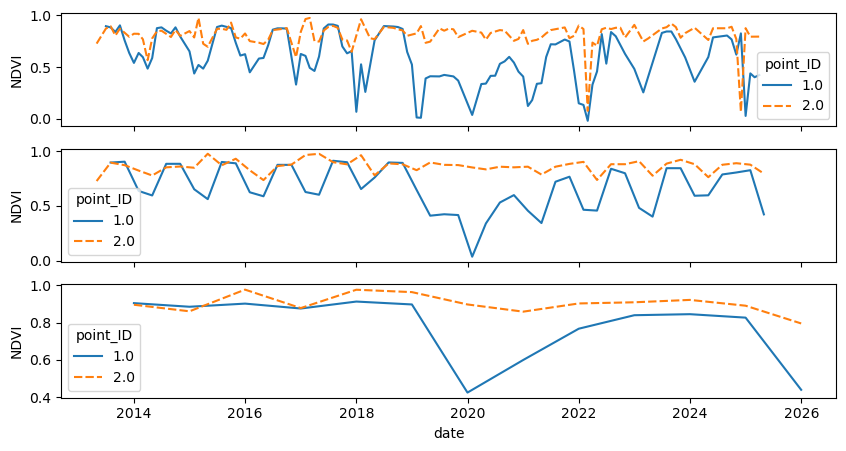

In [21]:
fig, axes = plt.subplots(3,1, figsize=(10, 5), sharex=True)
sns_plot = sns.lineplot(data = tsPandas_monthly, ax=axes[0])
sns_plot = sns.lineplot(data = tsPandas_3monthly, ax=axes[1])
sns_plot = sns.lineplot(data = tsPandas_yearly, ax=axes[2])
for ax in axes:
    ax.set_ylabel('NDVI')

Of course we can also plot the time series with matplotlib.

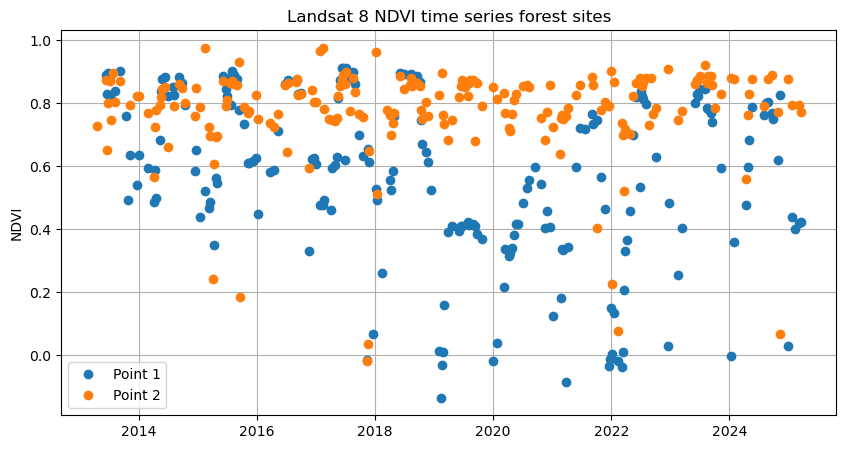

In [25]:
plt.figure(figsize=(10,5))
plt.plot_date(tsPandas_pv.index, tsPandas_pv)
plt.title("Landsat 8 NDVI time series forest sites")
plt.ylabel("NDVI")
plt.legend(['Point 1', 'Point 2'])
plt.grid(True)
plt.show()

## Interpretation

Looking at the NDVI time series for the two points, we see a seasonal cycle and some variation between different years. The variation is stronger for the yearly minima than for the yearly maxima, maybe because the minima are affected by snow and Landsat 8 did not always capture the (relatively short-lived) situations with a lot of snow on the canopy.

However, what is apparent in all these spectral trajectories is that point 1 (the disturbed forest site) has an unusually low NDVI in summer 2019, compared to the previous years, whereas the NDVI of point 2 (the undisturbed site) maintains constantly high annual maxima. In the years 2020 and 2021, the annual NDVI maxima of point 1 have increased again. This pattern reflects the destruction of forest in winter 2019 (by an avalanche as we know in this case) with subsequent establishment or expansion of some vegetation in the following years (probably forbs and shrubs).